In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

## __CUDA ENABLING__

In [6]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [7]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)

tf.config.set_visible_devices(physical_devices[0], 'GPU')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Device: ", gpu)



Device:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## __DATA PREPARATION__

In [8]:
dataset , dataset_info = tfds.load('malaria' , with_info=True , as_supervised=True , shuffle_files=True , split = ['train'])

I0000 00:00:1744546738.928581     402 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [54]:
print(dataset)
print(dataset_info)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/unix/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    ci

In [9]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

 DATASET_SIZE = len(dataset)

 train_dataset = dataset.take(int(DATASET_SIZE * TRAIN_RATIO))

 val_test_dataset = dataset.skip(int(DATASET_SIZE * TRAIN_RATIO))
 val_dataset = val_test_dataset.take(int(DATASET_SIZE * VAL_RATIO))

 test_dataset = val_test_dataset.skip(int(DATASET_SIZE * VAL_RATIO))

 return train_dataset,val_dataset,test_dataset

In [10]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)

train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))


2025-04-13 12:19:03.992424: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-13 12:19:04.031637: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 12:19:05.375652: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(0))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

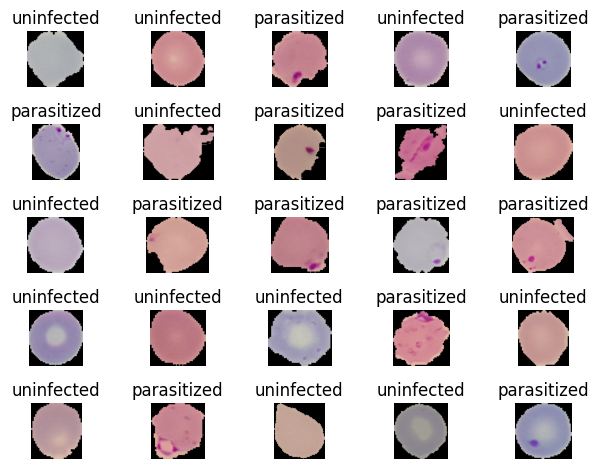

In [57]:
class_label = dataset_info.features['label']
for i , (image,label) in enumerate(train_dataset.take(25)):
    plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(class_label.int2str(label.numpy()))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
IMG_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image,(IMG_SIZE,IMG_SIZE))/255.0 ,label

In [12]:
train_dataset = train_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)

In [13]:
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## __CONVOLUTIONAL NEURAL NETWORK__

In [14]:
model = tf.keras.Sequential([
    InputLayer(shape=(IMG_SIZE,IMG_SIZE,3)),
    layers.Conv2D(filters = 6 , kernel_size = 3 , strides = 1 , padding = 'same' , activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = 2 , strides = 2),
    layers.Conv2D(filters = 16 , kernel_size = 3 , strides = 1 , padding = 'same' , activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = 2 , strides = 2),

    layers.Flatten(),

    Dense(100 , activation = 'relu'),
    layers.BatchNormalization(),
    Dense(10 , activation = 'relu'),
    layers.BatchNormalization(),
    Dense(1 , activation = 'sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     5,017,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,020,297 (19.15 MB)

 Trainable params: 5,020,033 (19.15 MB)

 Non-trainable params: 264 (1.03 KB)

In [15]:
model.compile(optimizer=Adam() , loss=BinaryCrossentropy() , metrics = ['accuracy'])

In [16]:
history = model.fit( train_dataset , validation_data = val_dataset , epochs = 16 , verbose = 1)

Epoch 1/16


I0000 00:00:1744546768.125971     493 service.cc:152] XLA service 0x7fc25c830d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744546768.126085     493 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-13 12:19:28.189792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744546768.489059     493 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/689 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5735 - loss: 0.8096

I0000 00:00:1744546771.799599     493 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.7552 - loss: 0.4966 - val_accuracy: 0.9267 - val_loss: 0.2609
Epoch 2/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9180 - loss: 0.2171 - val_accuracy: 0.9318 - val_loss: 0.1948
Epoch 3/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.9383 - loss: 0.1765 - val_accuracy: 0.9412 - val_loss: 0.2050
Epoch 4/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.9524 - loss: 0.1353 - val_accuracy: 0.9459 - val_loss: 0.2313
Epoch 5/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.9602 - loss: 0.1077 - val_accuracy: 0.9441 - val_loss: 0.1617
Epoch 6/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9713 - loss: 0.0780 - val_accuracy: 0.9405 - val_loss: 0.1804
Epoch 7/16
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9793 - loss: 0.0605 

2025-04-13 12:22:24.454899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.9793 - loss: 0.0605 - val_accuracy: 0.9459 - val_loss: 0.1589
Epoch 8/16
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9828 - loss: 0.0504 

2025-04-13 12:22:50.533578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.9828 - loss: 0.0504 - val_accuracy: 0.9506 - val_loss: 0.1884
Epoch 9/16
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9736 - loss: 0.0744 

2025-04-13 12:23:14.373408: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9736 - loss: 0.0744 - val_accuracy: 0.9263 - val_loss: 0.3236
Epoch 10/16
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9856 - loss: 0.0428 

2025-04-13 12:23:44.147522: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9856 - loss: 0.0429 - val_accuracy: 0.9579 - val_loss: 0.1258
Epoch 11/16
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9892 - loss: 0.0330 

2025-04-13 12:24:09.451886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.9892 - loss: 0.0330 - val_accuracy: 0.9557 - val_loss: 0.1772
Epoch 12/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9949 - loss: 0.0190 

2025-04-13 12:24:31.772430: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.9949 - loss: 0.0190 - val_accuracy: 0.9601 - val_loss: 0.1647
Epoch 13/16
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9969 - loss: 0.0126 

2025-04-13 12:24:58.118513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9969 - loss: 0.0126 - val_accuracy: 0.9535 - val_loss: 0.2123
Epoch 14/16
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9944 - loss: 0.0181 

2025-04-13 12:25:23.842753: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.9944 - loss: 0.0181 - val_accuracy: 0.9495 - val_loss: 0.1939
Epoch 15/16
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9939 - loss: 0.0181 

2025-04-13 12:25:50.514375: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.9939 - loss: 0.0181 - val_accuracy: 0.9652 - val_loss: 0.1880
Epoch 16/16
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9949 - loss: 0.0154 

2025-04-13 12:26:13.420808: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


689/689 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.9949 - loss: 0.0154 - val_accuracy: 0.9612 - val_loss: 0.2071


In [18]:
test_dataset = test_dataset.batch(1)

In [1]:
import gc
import tensorflow as tf
from keras import backend as K

# After model.fit()
K.clear_session()
gc.collect()


2025-04-13 12:17:16.628140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 12:17:16.916085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744546636.994709     402 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744546637.017076     402 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744546637.321111     402 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

0

In [19]:
model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9438 - loss: 0.3104


[0.3453442454338074, 0.9365252256393433]

In [31]:
parasite_or_not(model.predict(train_dataset.take(1))[0][0])

689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step


np.float32(0.99956125)

In [32]:
def parasite_or_not(x):
    if x>0.5:
        return 'U'
    else:
        return 'P'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


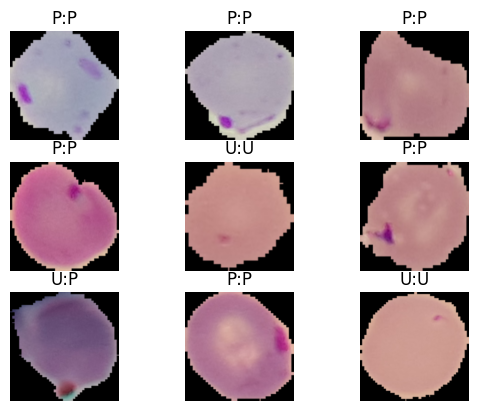

In [33]:
for i , (image,label) in enumerate(test_dataset.take(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0]))+ ':' + str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')